In [1]:
import numpy as np
import pylab as plt
import pyccl as ccl
import pyccl.nl_pt as pt
import pyccl.ccllib as lib
from astropy import units as u
from astropy.coordinates import Angle
%pylab inline 
from astropy.table import Table

# Preliminaries
Setting up a cosmology and defining the redshift distribution

In [2]:
#OuterRim:
#cosmo = ccl.Cosmology(
#    Omega_c=0.22, Omega_b=0.0448, 
#    h=0.71, sigma8 = 0.801, n_s= 0.963,w0=-1.00,wa=0.0, Omega_k=0.0)
#cosmo-SLICS model-fid:
cosmo = ccl.Cosmology(
    Omega_c=0.2458, Omega_b=0.0447, 
    h=0.6898, sigma8 = 0.836, n_s= 0.969,w0=-1.00,wa=0.0, Omega_k=0.0)

In [3]:
nzs=np.loadtxt("/global/homes/j/jharno/IA-infusion/SkySim5000/tools/SkySim5000_IA_infusion/StageIV_zcen_nz_bin1-5.dat", unpack = True)

In [4]:
z=nzs[0]
nzs_s=nzs[1:]

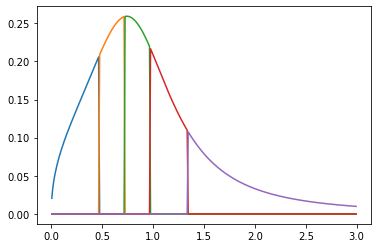

In [5]:
for i in range(len(nzs_s)):
    plot(z,nzs_s[i])

# IA normalization
these factors absorb the typical normalization factors used in the literature for intrinsic alignment amplitude and redshift evolution.

In [74]:
# Biases for IAs. Will be converted to the input c_IA values below.
a_1 = 1.0
a_2 = 0.0
a_d = 0.0

In [75]:
c_1,c_d,c_2 = pt.translate_IA_norm(cosmo, z, a1=a_1,
                                   Om_m2_for_c2 = False)

# Tracers
Let's create the 3 PTTracers

In [76]:
# Intrinsic alignments
ptt_i = pt.PTIntrinsicAlignmentTracer(c1=(z,c_1), c2=None, cdelta=None)
ptt_i_nla = pt.PTIntrinsicAlignmentTracer(c1=(z,c_1)) # to compare using the standard WLTracer

# Matter
ptt_m = pt.PTMatterTracer()


In [77]:
# with_NC (bool) – set to True if you’ll want to use this calculator to compute correlations involving number counts.
# with_IA (bool) – set to True if you’ll want to use this calculator to compute correlations involving intrinsic alignments.

# ptc = pt.PTCalculator(with_NC=True, with_IA=True,
#                       log10k_min=-5, log10k_max=3, low_extrap=-5, high_extrap=3, nk_per_decade=20)
ptc = pt.PTCalculator(with_NC=True, with_IA=True,
                      log10k_min=-5, log10k_max=3, low_extrap=-5, high_extrap=5, nk_per_decade=20)

# PT power spectra

In [78]:
# IAs x IAs
pk_ii, pk_ii_bb = pt.get_pt_pk2d(cosmo, ptt_i, tracer2=ptt_i, ptc=ptc, return_ia_ee_and_bb=True)
pk_ii_nla = pt.get_pt_pk2d(cosmo, ptt_i_nla, tracer2=ptt_i_nla, ptc=ptc,)

# IAs x matter
pk_im = pt.get_pt_pk2d(cosmo, ptt_i, tracer2=ptt_m, ptc=ptc)

# Matter x matter
pk_mm = pt.get_pt_pk2d(cosmo, ptt_m, tracer2=ptt_m, ptc=ptc)

In [79]:
ks = np.logspace(-4,2,512)
ps = {}
ps['ii'] = pk_ii.eval(ks, 1., cosmo)
ps['im'] = pk_im.eval(ks, 1., cosmo)
ps['mm'] = pk_mm.eval(ks, 1., cosmo)

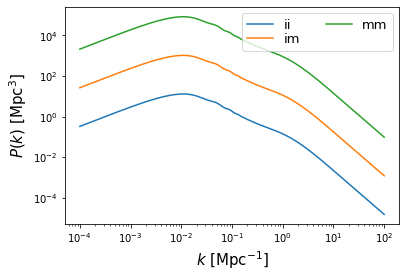

In [12]:
plt.figure()
for pn, p in ps.items():
    plt.plot(ks, abs(p), label=pn)
plt.loglog()
plt.legend(loc='upper right', ncol=2,
           fontsize=13, labelspacing=0.1)
plt.xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=15)
plt.ylabel(r'$P(k)\,\,[{\rm Mpc}^{3}]$', fontsize=15)
plt.show()

# Angular power spectra

In [81]:
# Lensing
tracers_len = []

for i in range(len(nzs_s)):
    t_l = ccl.WeakLensingTracer(cosmo, dndz=(z, nzs_s[i]))
    tracers_len.append(t_l)


In [82]:
# Intrinsic alignments
tracers_IA = []
for i in range(len(nzs_s)):
    t_i = ccl.WeakLensingTracer(cosmo, dndz=(z, nzs_s[i]), has_shear=False, ia_bias=(z, np.ones_like(z)), use_A_ia=False)
    tracers_IA.append(t_i)

In [83]:
# Intrinsic alignments
tracers_IA_nla = []
for i in range(len(nzs_s)):
    t_i_nla = ccl.WeakLensingTracer(cosmo, dndz=(z, nzs_s[i]), has_shear=False, ia_bias=(z, np.ones_like(z)), use_A_ia=True)
    tracers_IA_nla.append(t_i_nla)

In [16]:
ell = np.unique(np.geomspace(2,300000,10000).astype(int)).astype(float)

In [85]:
#ell = np.unique(np.geomspace(2,300000,10000).astype(int)).astype(float)
cls={}


cross=[]
for i in range(5):
    for j in range(i+1):
        cross.append(ccl.angular_cl(cosmo, tracers_len[i], tracers_len[j], ell,p_of_k_a=pk_mm))
cls['GG'] = np.stack(cross)

cross=[]
for i in range(5):
    for j in range(i+1):
        cross.append(ccl.angular_cl(cosmo, tracers_IA[i], tracers_IA[j], ell,p_of_k_a=pk_ii))
cls['II'] = np.stack(cross)

cross=[]
for i in range(5):
    for j in range(i+1):
        cross.append(ccl.angular_cl(cosmo, tracers_IA_nla[i], tracers_IA_nla[j], ell))
cls['II,NLA'] = np.stack(cross)


cross=[]
for i in range(5):
    for j in range(i+1):
        cross.append(ccl.angular_cl(cosmo, tracers_len[i],tracers_IA[j], ell, p_of_k_a=pk_im))
cls['GI'] =np.stack(cross)


cross=[]
for i in range(5):
    for j in range(i+1):
        cross.append(ccl.angular_cl(cosmo, tracers_len[i],tracers_IA_nla[j], ell))
cls['GI,NLA'] =np.stack(cross)

In [86]:
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
        plt.xlabel(r'$\theta$', fontsize=15)
        plt.ylabel(r'$\xi_+(\theta)$', fontsize=15)
    return axs[:N]

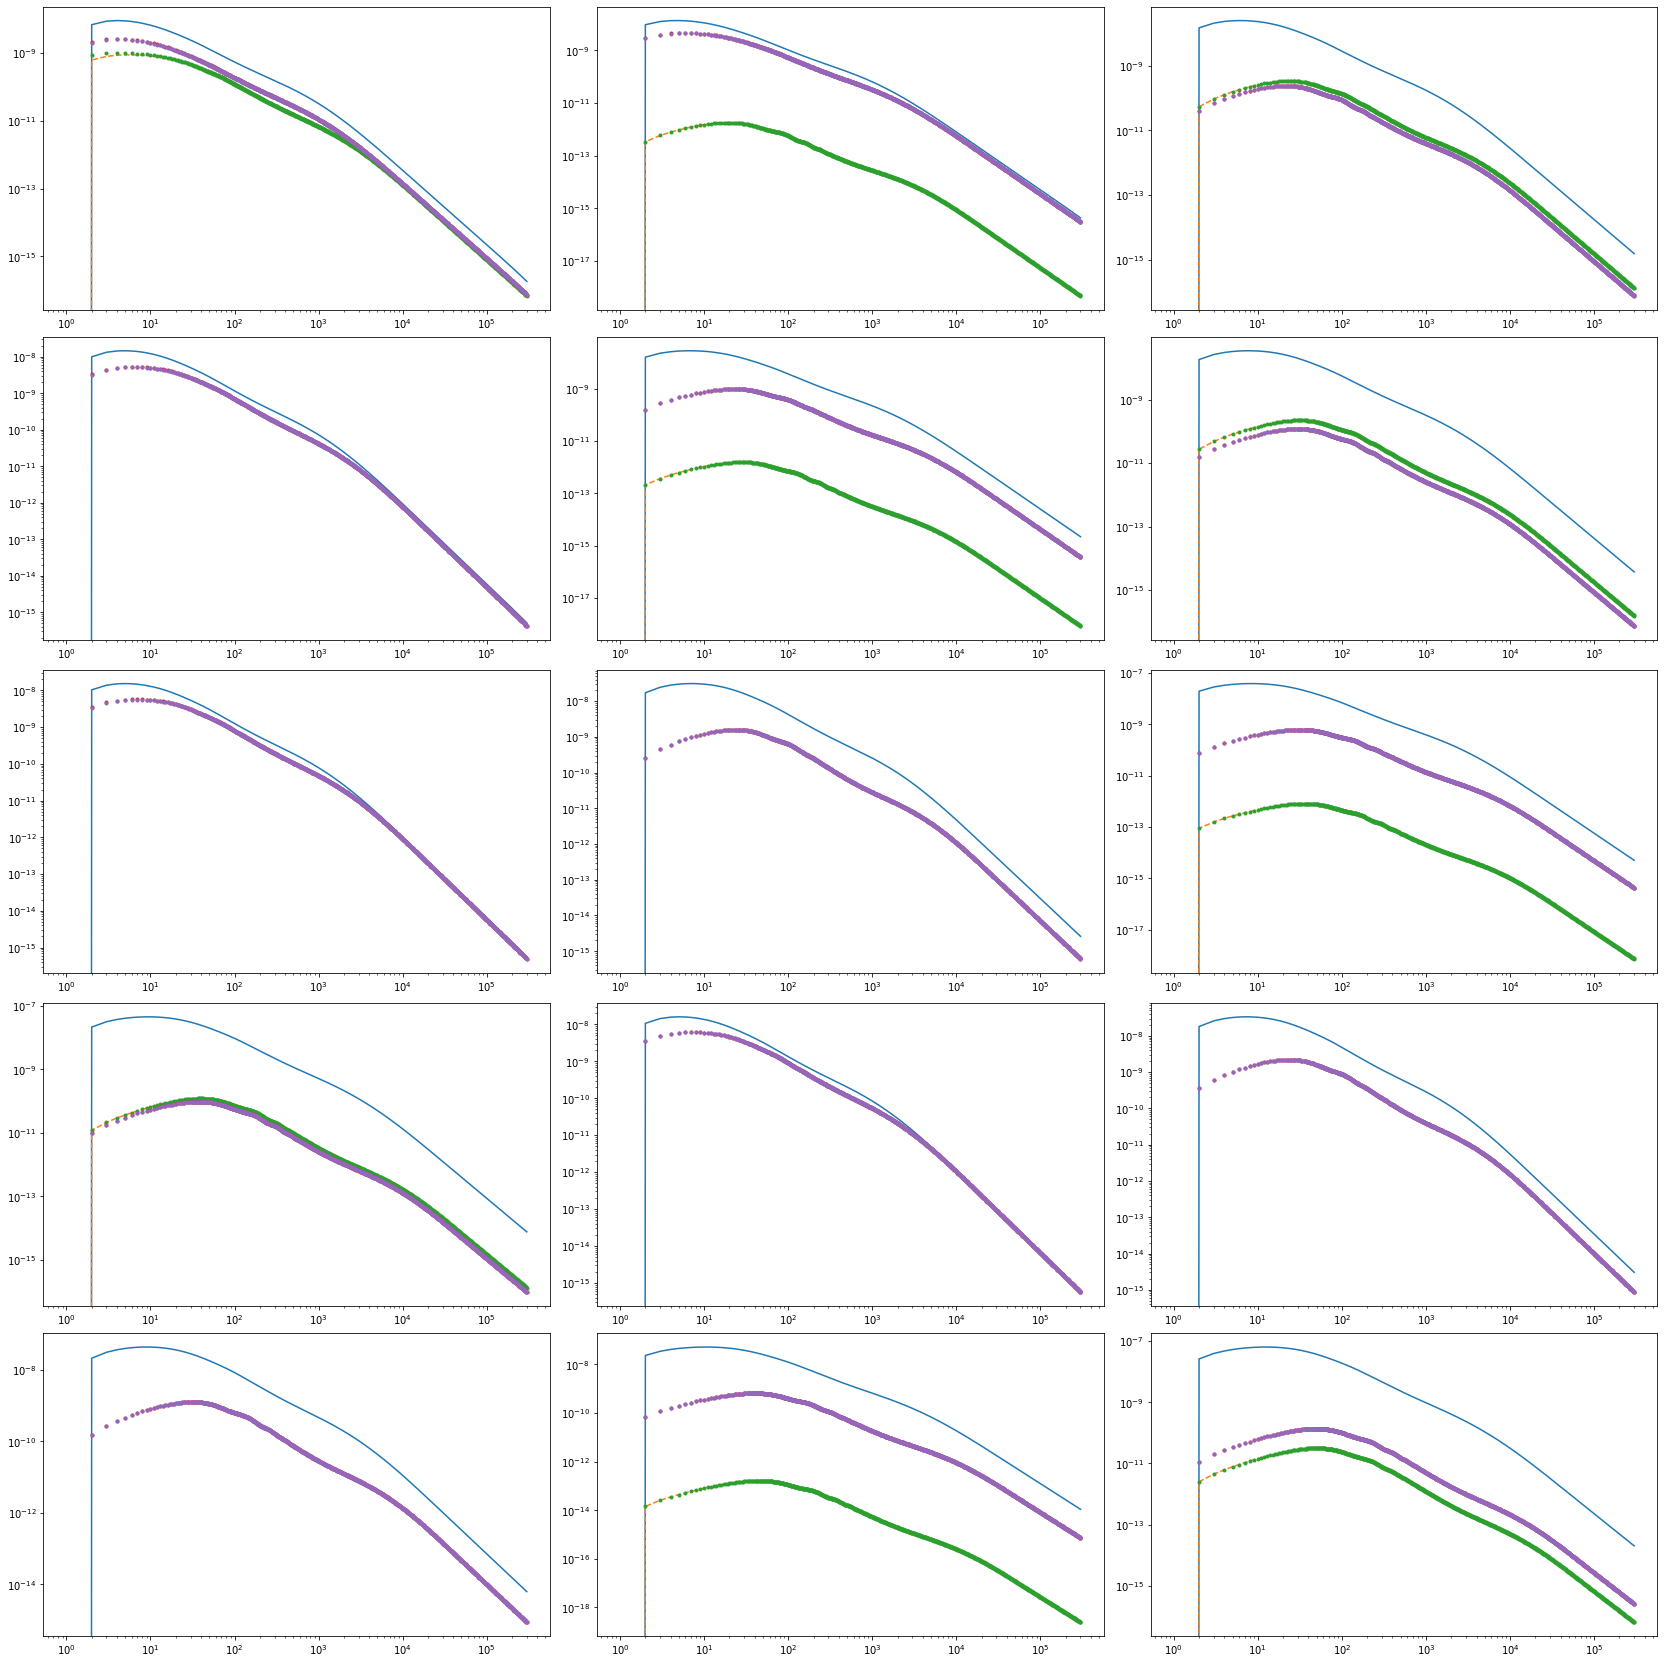

In [87]:
k=ell
figsize = (23, 23)
fig =plt.figure(figsize=figsize, constrained_layout=True)
cols = 3
rows =5
axs = fig.subplots(rows, cols)
axs = trim_axs(axs, len(cls['GG']))
for ax, pi in zip(axs, cls['GG']):
    ax.loglog(ell, pi,label='No IA')
for ax, px in zip(axs, cls['II,NLA']):
    ax.loglog(ell, px,'--',label='II,NLA')
for ax, pj in zip(axs, cls['II']):
    ax.loglog(ell, pj,'.',label='II')
for ax, pjk in zip(axs, cls['GI']):
    ax.loglog(ell,-pjk,'.',label='-GI')
for ax, pjj in zip(axs, cls['GI,NLA']):
    ax.loglog(ell, -pjj,'.',label='-GI,NLA')

#     plt.xlabel(r'$\ell$', fontsize=15)
#     plt.ylabel(r'$\C_{\ell}(\ell)$', fontsize=15)
# legend(loc='upper right')

# Shear correlation function

In [20]:
theta=np.geomspace(0.1,510,1000)

In [89]:
theta_arc=Angle(theta,u.arcmin)

430

In [90]:
theta=theta_arc.deg

In [91]:
shear_GG_plus=[]
for i in range(15): 
    shear_GG_plus.append(ccl.correlation(cosmo, ell, cls['GG'][i] ,theta ,type = 'GG+', method='FFTLog'))
shear_GG_plus=np.stack(shear_GG_plus)

/global/common/software/lsst/common/miniconda/dev-v1r1/envs/desc/lib/python3.9/site-packages/pyccl/correlations.py:83: CCLWarning: corr_type is deprecated. Use type = GG+
  warnings.warn("corr_type is deprecated. Use type = {}".format(type),


In [92]:
shear_GG_minus=[]
for i in range(15): 
    shear_GG_minus.append(ccl.correlation(cosmo, ell, cls['GG'][i] ,theta, type = 'GG-', method='FFTLog'))
shear_GG_minus=np.stack(shear_GG_minus)

/global/common/software/lsst/common/miniconda/dev-v1r1/envs/desc/lib/python3.9/site-packages/pyccl/correlations.py:83: CCLWarning: corr_type is deprecated. Use type = GG-
  warnings.warn("corr_type is deprecated. Use type = {}".format(type),


In [93]:
shear_II_NLA_plus=[]
for i in range(15): 
    shear_II_NLA_plus.append(ccl.correlation(cosmo, ell,cls['II,NLA'][i] ,theta , type = 'GG+', method='FFTLog'))
shear_II_NLA_plus=np.stack(shear_II_NLA_plus)

In [94]:
shear_II_NLA_minus=[]
for i in range(15): 
    shear_II_NLA_minus.append(ccl.correlation(cosmo, ell,cls['II,NLA'][i] ,theta , type = 'GG-', method='FFTLog'))
shear_II_NLA_minus=np.stack(shear_II_NLA_minus)

In [95]:
shear_II_plus=[]
for i in range(15): 
    shear_II_plus.append(ccl.correlation(cosmo, ell,cls['II'][i] ,theta , type = 'GG+', method='FFTLog'))
shear_II_plus=np.stack(shear_II_plus)

In [96]:
shear_II_minus=[]
for i in range(15): 
    shear_II_minus.append(ccl.correlation(cosmo, ell,cls['II'][i] ,theta , type = 'GG-', method='FFTLog'))
shear_II_minus=np.stack(shear_II_minus)

In [97]:
shear_GI_plus=[]
for i in range(15): 
    shear_GI_plus.append(ccl.correlation(cosmo, ell,cls['GI'][i] ,theta , type = 'GG+', method='FFTLog'))
shear_GI_plus=np.stack(shear_GI_plus)

In [98]:
shear_GI_minus=[]
for i in range(15): 
    shear_GI_minus.append(ccl.correlation(cosmo, ell,cls['GI'][i] ,theta , type = 'GG-', method='FFTLog'))
shear_GI_minus=np.stack(shear_GI_minus)

In [99]:
shear_GI_NLA_plus=[]
for i in range(15): 
    shear_GI_NLA_plus.append(ccl.correlation(cosmo, ell,cls['GI,NLA'][i] ,theta , type = 'GG+', method='FFTLog'))
shear_GI_NLA_plus=np.stack(shear_GI_NLA_plus)

In [100]:
shear_GI_NLA_minus=[]
for i in range(15): 
    shear_GI_NLA_minus.append(ccl.correlation(cosmo, ell,cls['GI,NLA'][i] ,theta ,type = 'GG-',method='FFTLog'))
shear_GI_NLA_minus=np.stack(shear_GI_NLA_minus)

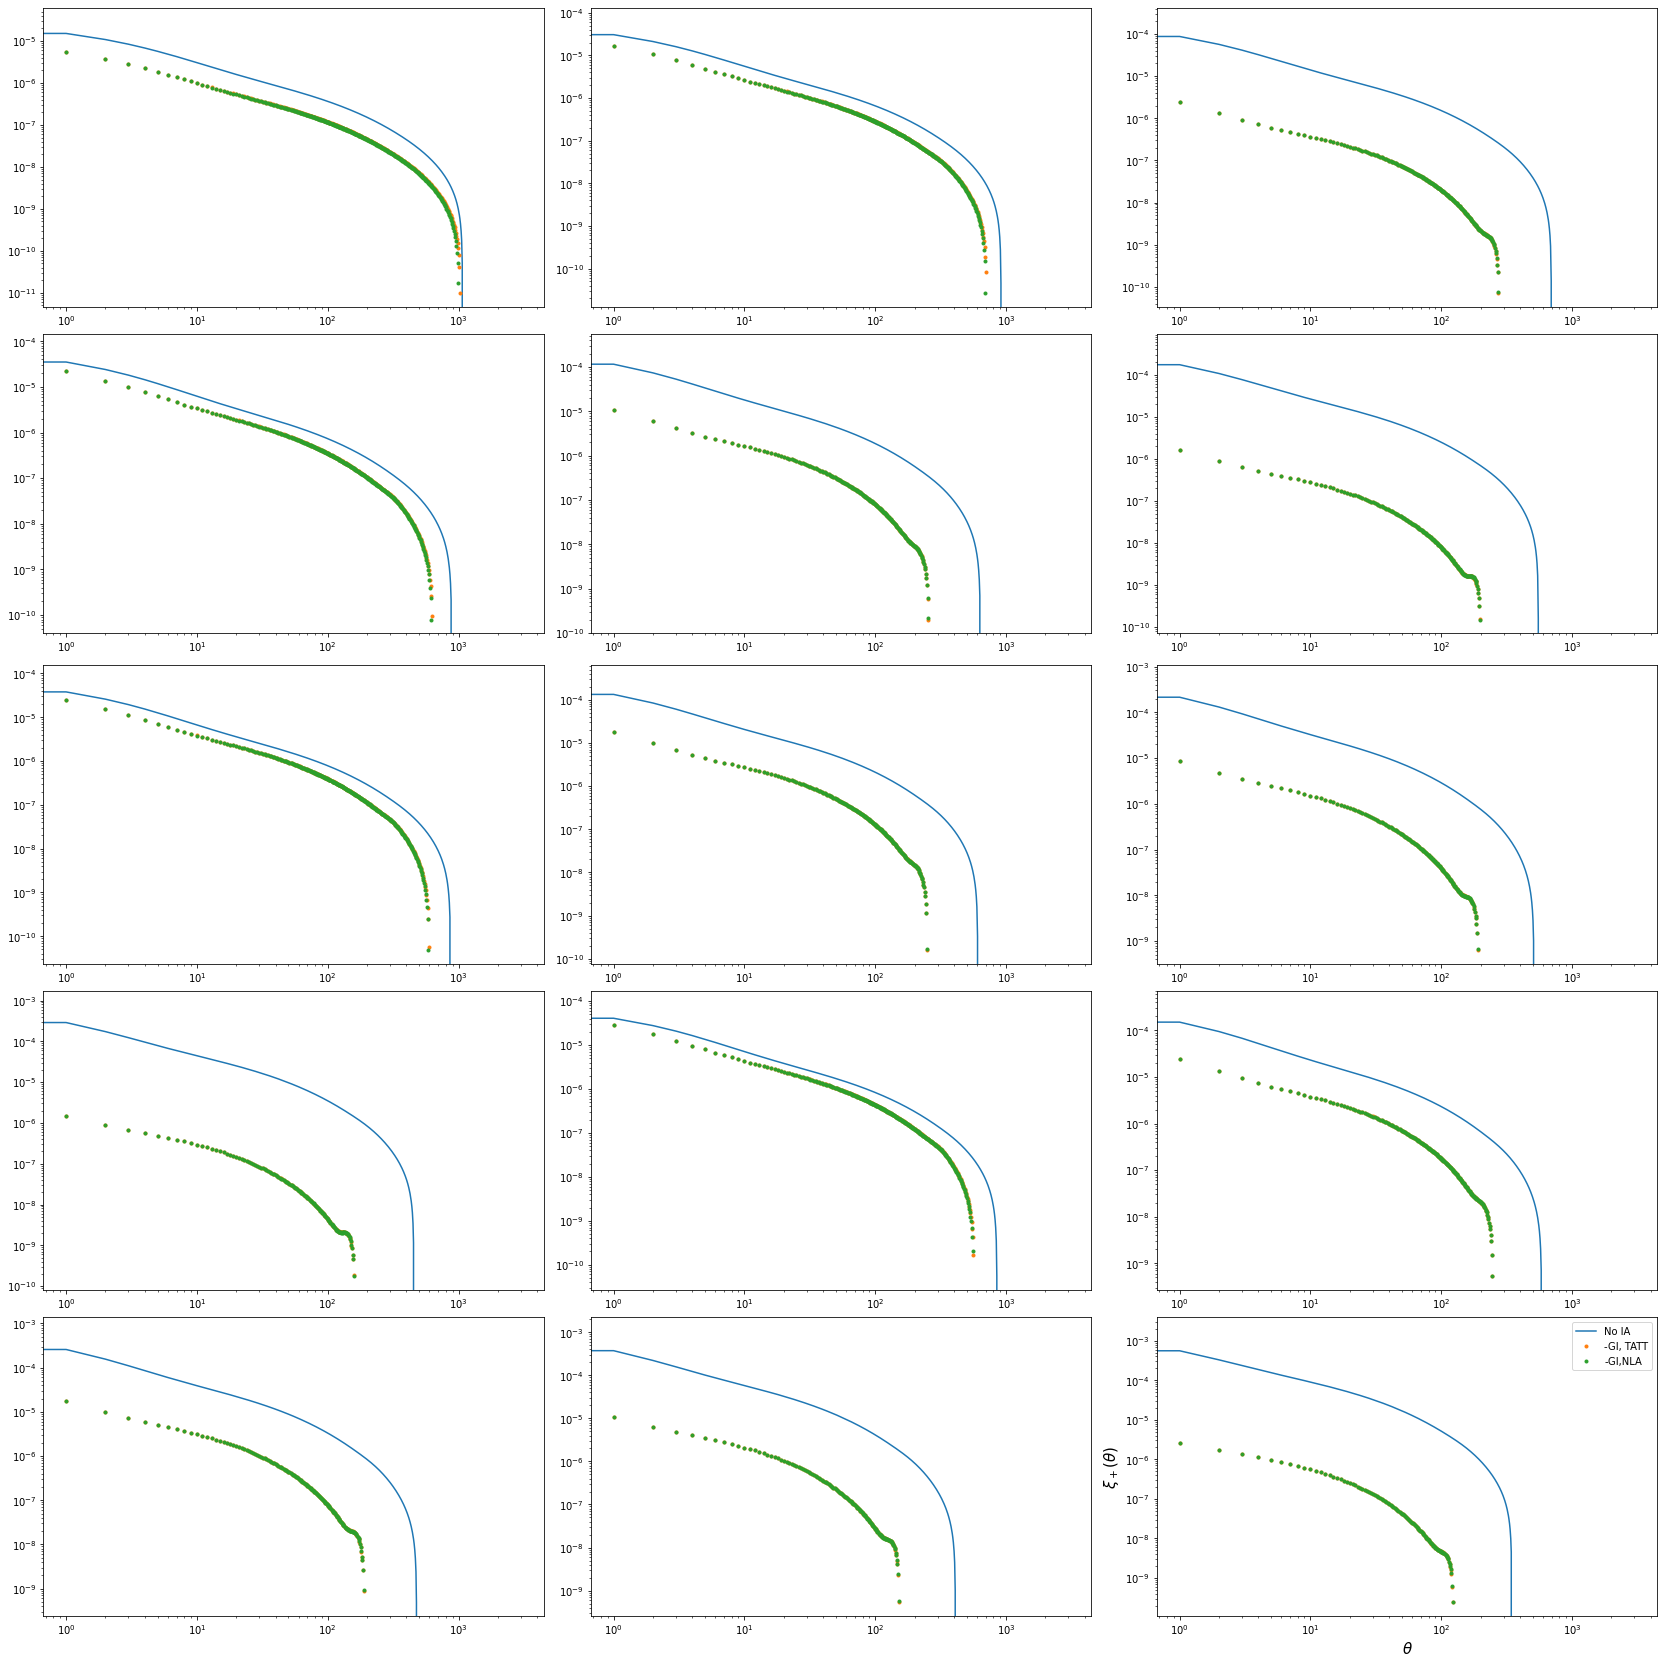

In [101]:
figsize = (23, 23)
fig =plt.figure(figsize=figsize, constrained_layout=True)
cols = 3
rows =5
axs = fig.subplots(rows, cols)
axs = trim_axs(axs, len(shear_GG_plus))
for ax, pi in zip(axs, shear_GG_plus):
    ax.loglog(theta_arc, pi,label='No IA')
for ax, px in zip(axs, shear_II_NLA_plus):
    ax.loglog(theta_arc, px,'--',label='II,NLA')
for ax, pj in zip(axs, shear_II_plus):
    ax.loglog(theta_arc, pj,'.',label='II')
for ax, pjk in zip(axs, shear_GI_plus):
    ax.loglog(theta,-pjk,'.',label='-GI, TATT')
for ax, pjj in zip(axs, shear_GI_NLA_plus):
    ax.loglog(theta_arc, -pjj,'.',label='-GI,NLA')
    plt.xlabel(r'$\theta$(arcmin)', fontsize=15)
    plt.ylabel(r'$\xi_+(\theta)$', fontsize=15)
xlim()
legend(loc='upper right')
#fig.savefig("pos_cross.png",dpi=250)

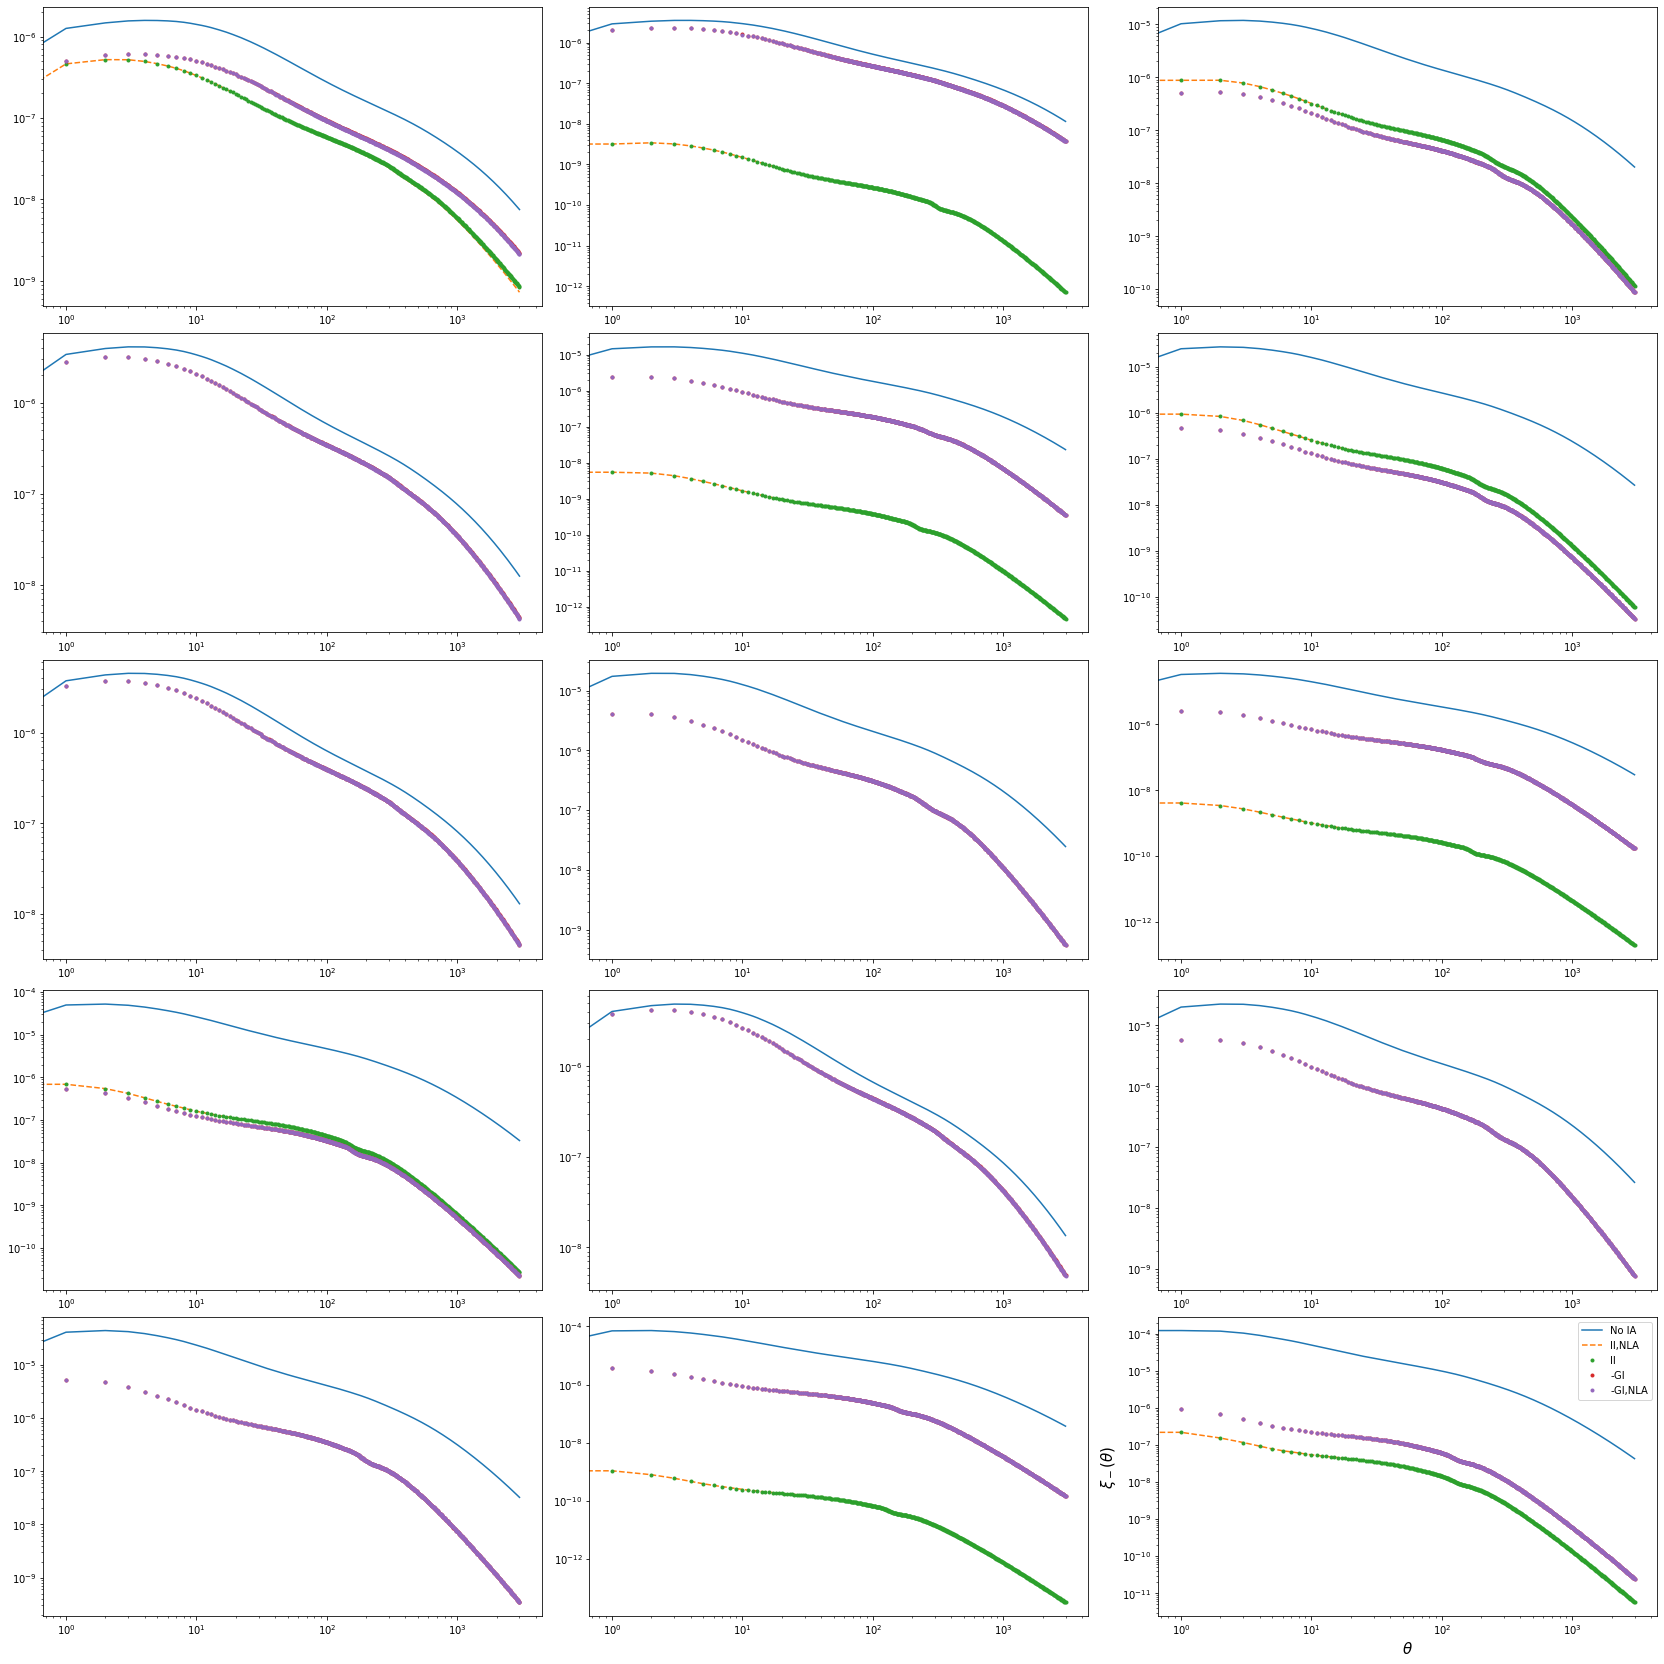

In [102]:

figsize = (23, 23)
fig =plt.figure(figsize=figsize, constrained_layout=True)
cols = 3
rows =5
axs = fig.subplots(rows, cols)
axs = trim_axs(axs, len(shear_GG_minus))

for ax, pi in zip(axs, shear_GG_minus):
    ax.loglog(theta_arc, pi,label='No IA')
for ax, pj in zip(axs, shear_II_minus):
    ax.loglog(theta_arc, pj,'.',label='II')
for ax, px in zip(axs, shear_II_NLA_minus):
    ax.loglog(theta_arc, px,'--',label='II,NLA')
for ax, pjk in zip(axs, shear_GI_minus):
    ax.loglog(theta_arc,-pjk,'.',label='-GI')
for ax, pjj in zip(axs, shear_GI_NLA_minus):
    ax.loglog(theta_arc, -pjj,'.',label='-GI,NLA')
plt.xlabel(r'$\theta$(arcmin)', fontsize=15)
plt.ylabel(r'$\xi_-(\theta)$', fontsize=15)

legend(loc='upper right')
#fig.savefig("neg_cross.png",dpi=250)

In [103]:
names=('NO IA+','NO IA-','GI+','GI-','GI_NLA+','GI_NLA-','II+','II-','II_NLA+','II_NLA-','theta', 'bin_comb' )

In [104]:
index=[]
for i in range(5):
    for j in range(i+1):
        index.append([i+1,j+1])
index=np.stack(index)

In [105]:
thetax=[]
for i in range(len(shear_GG_plus)):
    thetax.append(theta)

In [106]:
theta=np.stack(thetax)

In [107]:

t = Table([shear_GG_plus,shear_GG_minus, shear_GI_plus,shear_GI_minus,shear_GI_NLA_plus,shear_GI_NLA_minus,shear_II_plus,shear_II_minus,shear_II_NLA_plus,shear_II_NLA_minus,theta,np.stack(index)], names=names)
#t.write('theory/CCL/theo_prediction_0.0_0.0_1.0_V2.fits', format='fits')
#t.write('theory/CCL/theo_prediction_1.0_1.0_1.0_cosmoSLICS_fid.fits', format='fits')
#t.write('theory/CCL/theo_prediction_1.0_1.0_0.0_cosmoSLICS_fid.fits', format='fits')
t.write('theory/CCL/theo_prediction_1.0_0.0_0.0_cosmoSLICS_fid.fits', format='fits')


In [81]:
t

NO IA+ [430],NO IA- [430],GI+ [430],GI- [430],GI_NLA+ [430],GI_NLA- [430],II+ [430],II- [430],II_NLA+ [430],II_NLA- [430],theta [430],bin_comb [2]
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
2.193782324265003e-05 .. 7.27046286682746e-11,7.298734681372441e-07 .. 1.6515552992011513e-09,-1.5062173294464439e-05 .. -2.5333636376586272e-11,-3.1023259022201895e-07 .. -6.947775553979207e-10,-8.093205106051553e-06 .. -2.281759008610455e-11,-2.400070199820809e-07 .. -5.416897835462611e-10,1.8413768989909932e-05 .. 1.687778328499822e-11,2.1471263040876434e-07 .. 4.765229654353096e-10,6.112921885475748e-06 .. 1.156288712847971e-11,1.3449923558840573e-07 .. 3.0163060435992276e-10,0.0 .. 3000.0,1 .. 1
4.731891839847638e-05 .. 1.3246921490716033e-10,1.3929701172987248e-06 .. 3.1438094766463413e-09,-5.235162910852284e-05 .. -6.257551007957632e-11,-7.690649827582446e-07 .. -1.7148057471759776e-09,-2.8554156828986515e-05 .. -5.838586694010696e-11,-6.634843630746365e-07 .. -1.4900935296320725e-09,1.015837485793687e-07 .. 4.16483446099845e-14,5.809881173549604e-10 .. 1.258767684739436e-12,3.5529665638393655e-08 .. 3.371752117168593e-14,5.297677444463855e-10 .. 1.1708763004731e-12,0.0 .. 3000.0,2 .. 1
0.0001517891231022172 .. 3.1934538930821854e-10,3.622200344645365e-06 .. 8.137753160430132e-09,-1.001429180916605e-05 .. -4.4185576550609515e-12,-7.887839058349382e-08 .. -1.7142720971642212e-10,-5.766682860286872e-06 .. -3.788212162178413e-12,-7.728966366921968e-08 .. -1.6945088775254348e-10,2.4443879779006316e-05 .. 6.717212236044703e-12,1.1689062412124031e-07 .. 2.4925739201681097e-10,8.951340610802788e-06 .. 4.3394827973756605e-12,1.0807805501529039e-07 .. 2.355948287101442e-10,0.0 .. 3000.0,2 .. 2
5.5073219189947706e-05 .. 1.4681377055319497e-10,1.5791743634848263e-06 .. 3.5601444023550116e-09,-7.052615455404709e-05 .. -7.846132314370765e-11,-9.668735896114795e-07 .. -2.1532366977144752e-09,-3.8612318490408026e-05 .. -7.3382940349369e-11,-8.51008896754146e-07 .. -1.9088190139641803e-09,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 3000.0,3 .. 1
0.00020823559137326305 .. 3.9814426687721703e-10,4.644268182503171e-06 .. 1.0416462228228457e-08,-4.53184233719697e-05 .. -1.7094774985018967e-11,-3.3627963815977895e-07 .. -7.276411503802162e-10,-2.6362754743249963e-05 .. -1.4241632176039787e-11,-3.29829004957827e-07 .. -7.203665611433739e-10,1.3604360827285303e-07 .. 2.7154435931830016e-14,5.57956857065157e-10 .. 1.172797483957462e-12,5.187899212618738e-08 .. 1.2808534566536803e-14,5.199901857365783e-10 .. 1.120728272941774e-12,0.0 .. 3000.0,3 .. 2
0.0003361493795773291 .. 5.272200156597877e-10,6.6405537255023254e-06 .. 1.4833895769438476e-08,-7.64651711886697e-06 .. -1.4322488743385437e-12,-4.379965467360538e-08 .. -9.293169169783956e-11,-4.649900804535279e-06 .. -9.45344285367695e-13,-4.3060824718154854e-08 .. -9.247781524034738e-11,2.1995817095672212e-05 .. 3.635920651331351e-12,8.057424997609694e-08 .. 1.6745694038095284e-10,8.713538492670786e-06 .. 1.4397314659700449e-12,7.526632514391125e-08 .. 1.6104857263516723e-10,0.0 .. 3000.0,3 .. 3
5.9804789463640265e-05 .. 1.586838591851918e-10,1.6927913317092752e-06 .. 3.8173274202415435e-09,-8.161668698679011e-05 .. -8.81592458984647e-11,-1.0875778288034715e-06 .. -2.4207751632430504e-09,-4.47500235543589e-05 .. -8.252133822762209e-11,-9.654354728344941e-07 .. -2.1643140250162884e-09,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 3000.0,4 .. 1
0.00024359081953228464 .. 4.454576543220814e-10,5.2789939398115955e-06 .. 1.1829750554831588e-08,-7.47741508225847e-05 .. -2.699190592460413e-11,-5.458293670831921e-07 .. -1.1796258569816636e-09,-4.361763287958651e-05 .. -2.228113047571407e-11,-5.354916973054038e-07 .. -1.1683081818777472e-09,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 3000.0,4 .. 2
0.00043331490902400523 .. 6.141303471235302e-10,8.055230949400539e-06 .. 1.7956821387462e-08,-4.154654404395155e-05 .. -7.050857742535785e-12,-2.278255136